# 1. Event approach

 ## Reading the full stats file

In [1]:
import numpy
import pandas

In [2]:
full_stats_file = '/Users/irv033/Downloads/data/stats_example.csv'
df = pandas.read_csv(full_stats_file)

In [3]:
def date_only(x):
    """Chop a datetime64 down to date only"""
    
    x = numpy.datetime64(x)
    
    return numpy.datetime64(numpy.datetime_as_string(x, timezone='local')[:10])

In [4]:
#df.time = df.time.apply(lambda x: numpy.datetime64(x))
df.time = df.time.apply(date_only)

#print pandas.to_datetime(df['time'].values)
#df_times = df.time.apply(lambda x: x.date())

In [5]:
df = df.set_index('time')

## Read xarray data frame

In [6]:
import xray

In [7]:
data_file = '/Users/irv033/Downloads/data/va_ERAInterim_500hPa_2006-030day-runmean_native.nc'
dset_in = xray.open_dataset(data_file)

In [8]:
print dset_in

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 365)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 -90.0 -89.25 -88.5 -87.75 -87.0 -86.25 ...
  * time       (time) datetime64[ns] 2006-01-01T06:00:00 2006-01-02T06:00:00 ...
Data variables:
    va         (time, latitude, longitude) float64 -3.818 -3.803 -3.787 ...
Attributes:
    CDI: Climate Data Interface version 1.5.3 (http://code.zmaw.de/projects/cdi)
    Conventions: CF-1.0
    history: Mon Jun 15 13:04:23 2015: ncatted -O -a axis,time,c,c,T va_ERAInterim_500hPa_2006-030day-runmean_native.nc
Mon Jun 15 13:04:23 2015: ncatted -O -a missing_value,va,o,f,-32767. va_ERAInterim_500hPa_2006-030day-runmean_native.nc
Mon Jun 15 13:03:30 2015: cdo seldate,2006-01-01,2006-12-31 va_ERAInterim_500hPa_030day-runmean_native.nc va_ERAInterim_500hPa_2006-030day-runmean_native.nc
Fri Mar 20 07:35:31 2015: ncatted -O -a axis,time,c,c,T /mnt/meteo0/d

In [9]:
darray = dset_in['va']

In [10]:
print darray

<xarray.DataArray 'va' (time: 365, latitude: 241, longitude: 480)>
[42223200 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 -90.0 -89.25 -88.5 -87.75 -87.0 -86.25 ...
  * time       (time) datetime64[ns] 2006-01-01T06:00:00 2006-01-02T06:00:00 ...
Attributes:
    standard_name: northward_wind
    long_name: northward_wind
    units: m s**-1
    level: 500hPa


In [11]:
times = darray.time.values

In [12]:
date_only(times[5])

numpy.datetime64('2006-01-06')

In [13]:
darray_times = map(date_only, list(times))
print darray_times[0:5]

[numpy.datetime64('2006-01-01'), numpy.datetime64('2006-01-02'), numpy.datetime64('2006-01-03'), numpy.datetime64('2006-01-04'), numpy.datetime64('2006-01-05')]


## Merge

### Re-index the event data 

In [14]:
event_numbers = df['event_number']

In [15]:
event_numbers = event_numbers.reindex(darray_times)

### Broadcast the shape

In [16]:
print darray

<xarray.DataArray 'va' (time: 365, latitude: 241, longitude: 480)>
[42223200 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 -90.0 -89.25 -88.5 -87.75 -87.0 -86.25 ...
  * time       (time) datetime64[ns] 2006-01-01T06:00:00 2006-01-02T06:00:00 ...
Attributes:
    standard_name: northward_wind
    long_name: northward_wind
    units: m s**-1
    level: 500hPa


In [17]:
print darray.shape
print type(darray)

(365, 241, 480)
<class 'xarray.core.dataarray.DataArray'>


In [18]:
print type(event_numbers.values)

<type 'numpy.ndarray'>


In [19]:
type(darray.data)

numpy.ndarray

In [20]:
event_data = numpy.zeros((365, 241, 480))
for i in range(0,365):
    event_data[i,:,:] = event_numbers.values[i]

### Cobmine

In [21]:
d = {}
d['time'] = darray['time']
d['latitude'] = darray['latitude']
d['longitude'] = darray['longitude']

d['va'] = (['time', 'latitude', 'longitude'], darray.data)
d['event'] = (['time'], event_numbers.values)

ds = xray.Dataset(d)

In [22]:
print ds

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 365)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.25 -88.5 -87.75 -87.0 -86.25 ...
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * time       (time) datetime64[ns] 2006-01-01T06:00:00 2006-01-02T06:00:00 ...
Data variables:
    va         (time, latitude, longitude) float64 -3.818 -3.803 -3.787 ...
    event      (time) float64 280.0 280.0 nan nan nan nan nan nan nan nan ...


## Get event averages

In [23]:
event_averages = ds.groupby('event').mean('time')

In [24]:
print event_averages

<xarray.Dataset>
Dimensions:    (event: 11, latitude: 241, longitude: 480)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.25 -88.5 -87.75 -87.0 -86.25 ...
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * event      (event) float64 280.0 281.0 282.0 283.0 284.0 285.0 286.0 ...
Data variables:
    va         (event, latitude, longitude) float64 -3.91 -3.895 -3.88 ...


# 2. Standard autocorrelation approach

### Read data

In [25]:
tas_file = '/Users/irv033/Downloads/data/tas_ERAInterim_surface_030day-runmean-anom-wrt-all-2005-2006_native.nc'
tas_dset = xray.open_dataset(tas_file)

tas_darray = tas_dset['tas']
print tas_darray

<xarray.DataArray 'tas' (time: 730, latitude: 241, longitude: 480)>
[84446400 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 3.0 3.75 4.5 5.25 6.0 ...
  * latitude   (latitude) float32 -90.0 -89.25 -88.5 -87.75 -87.0 -86.25 ...
  * time       (time) datetime64[ns] 2005-01-01T06:00:00 2005-01-02T06:00:00 ...
Attributes:
    standard_name: surface_air_temperature
    long_name: surface_air_temperature
    units: K
    level: 2m


In [26]:
tas_data = tas_darray[dict(longitude=130, latitude=-40)].values
print tas_data.shape

(730,)


### Plot autocorrelation with Pandas 

In [30]:
%matplotlib inline

In [37]:
from pandas.tools.plotting import autocorrelation_plot

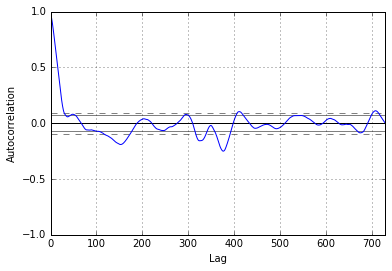

In [41]:
pandas_test_data = pandas.Series(tas_data)
autocorrelation_plot(pandas_test_data)

### Calculate autocorrelation with statsmodels

In [39]:
import statsmodels

In [40]:
from statsmodels.tsa.stattools import acf

In [51]:
statsmodels_test_data = acf(tas_data, nlags=n-2)

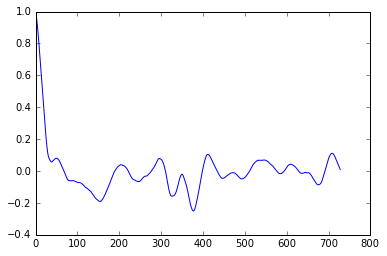

In [52]:
import matplotlib.pyplot as plt
plt.plot(k, statsmodels_test_data[1:])

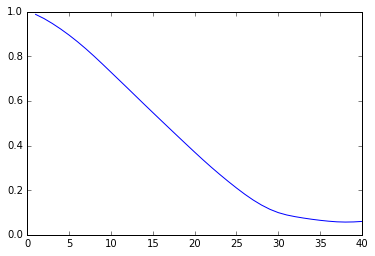

In [56]:
plt.plot(k[0:40], statsmodels_test_data[1:41])

In [54]:
# Formula from Zieba2010, equation 12

r_k_sum = ((n - k) / float(n)) * statsmodels_test_data[1:] 

n_eff = float(n) / (1 + 2 * numpy.sum(r_k_sum))
print n_eff

90.2736967616


In [55]:
print numpy.sum(r_k_sum)

3.54325969905


So an initial sample size of 730 has an effective sample size of 90.

### Get the p value

In [69]:
from scipy import stats

In [72]:
var_x = tas_data.var() / n_eff
tval = tas_data.mean() / numpy.sqrt(var_x)
pval = stats.t.sf(numpy.abs(tval), n - 1) * 2  # two-sided pvalue = Prob(abs(t)>tt)
print 't-statistic = %6.3f pvalue = %6.4f' % (tval, pval)

t-statistic =  0.577 pvalue = 0.5644
